<a href="https://colab.research.google.com/github/DrAlexSanz/micrograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this notebook

* Understand how does automatic differentiation work

Lecture here https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

In [42]:
import math
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
import random

import torch # for checking later

In [8]:
# Make a function to demonstrate operations
def f(x):
    return 3*x**2 - 4*x +5

f(3.0)

20.0

Text(0.5, 1.0, 'Beautiful parabola')

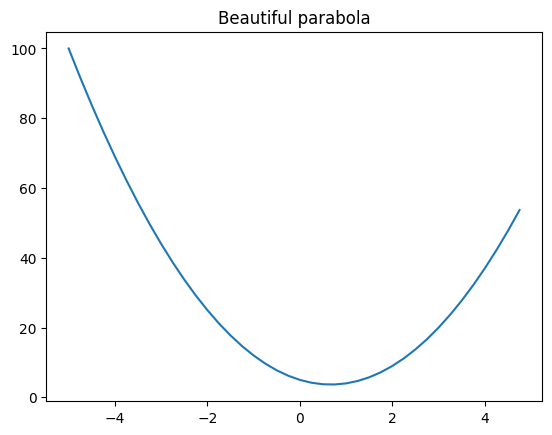

In [9]:
xs = np.arange(-5, 5, 0.25) # Now get a vector of inputs and pass it to the function for plotting

ys = f(xs)

plt.plot(xs, ys)
plt.title("Beautiful parabola")

Now, I could calculate the derivative using the rules because it's an easy one. Alternatively I can use the definition of derivative.

$$ f'(x) = lim_{x \rightarrow 0} \frac{f(x + h) - f(x)}{h} $$


In [10]:
# I define
h = 0.00001 # Too small and the numerator will underflow.
x = 3.0
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 20.0001400003
f(x) = 20.0
f'(3) = 14.00003000000538


In [11]:
# And now for the negative side, the derivative should be negative
h = 0.00001 # Too small and the numerator will underflow.
x = -3.0
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 43.9997800003
f(x) = 44.0
f'(3) = -21.999970000052823


In [12]:
# And now I know that the minimum is at 2/3 more or less
h = 0.00001 # Too small and the numerator will underflow.
x = 2/3
print(f"f(x + h) = {f(x + h)}")
print(f"f(x) = {f(x)}")
der = (f(x + h) - f(x))/h
print(f"f'(3) = {der}") # This should be 14 with a small error.


f(x + h) = 3.666666666966667
f(x) = 3.666666666666667
f'(3) = 3.0000002482211127e-05


Now let's do a more complicated function

In [13]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

print(d)

4.0


Let's evaluate the derivative of the new function with respect to a, b and c

In [14]:
h = 0.0001 # Too small and the numerator will underflow.

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c # This is f(x)

# d1/da
a = a + h # add h to a
d2 = a * b + c # This is f(x + h)

d1_da = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_da = ", d1_da) # This should be -3 for this point (using the rules)

# And this works the same way for b and c

# d1/db
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

b = b + h # add h to b
d2 = a * b + c # This is f(x + h)

d1_db = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_db = ", d1_db) # This should be 2 for this point (using the rules)

# d1/dc
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

c = c + h # add h to c
d2 = a * b + c # This is f(x + h)

d1_dc = (d2 - d1)/h

print("d1 = ", d1) # This should be 4
print("d2 = ", d2) # This should be close to 4 (smaller in this case)
print("d1_dc = ", d1_dc) # This should be 1 for this point (using the rules)

d1 =  4.0
d2 =  3.999699999999999
d1_da =  -3.000000000010772
d1 =  4.0
d2 =  4.0002
d1_db =  2.0000000000042206
d1 =  4.0
d2 =  4.0001
d1_dc =  0.9999999999976694


So this is an intuitive idea of how all this autodiff thing works.

Now we build the first draft of the Value object (class) of Micrograd

In [33]:
class Value():
    def __init__(self, data, _children = (), _op = "", label = ""): # _children starts as an empty tuple. Operation is a string (add, mul...)
        self.data = data
        self.grad = 0.0 # This will be the derivative, initialized to 0
        self._backward = lambda: None # Instead of implementing every derivative based on rules, I will do a generic one. By default, we don't need to do anything (leaf node)
        self._prev = set(_children) # Make it a set for efficiency. If I write a = Value(2.0), prev is the empty set.
        self._op = _op
        self.label = label

    def __repr__(self): # Instead of printing the memory address, print something readable
        return f"Value(data = {self.data})"
    
    def __add__(self, other): # Need to define what addition means
        other = other if isinstance(other, Value) else Value(other) # This one allows me to do a= Value(1.0); b = a + 1 (note that 1 is an int, not a Value, until i force it)
        out = Value(self.data + other.data, (self, other), "+") # Returns another Value object. And we define the symbol for the operation.
        def _backward(): # For addition, I want to propagate the grad into self grad, and other grad.
          self.grad += 1.0 * out.grad # Addition copies the gradient to each node, as we saw before.
          other.grad += 1.0 * out.grad # Gradients accumulate, if one node is used multiple times I need to account for all times.
        # _backward doesn't need to return anything
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        x = self.data
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __mul__(self, other): # Need to define what multiplication means
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*") # Returns another Value object. And we define the symbol for the operation.
        def _backward(): # For multiplication, I want to APPLY THE CHAIN RULE to propagate the grad into self grad, and other grad.
          self.grad += other.data * out.grad # Gradients accumulate, if one node is used multiple times I need to account for all times.
          other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self. This is a conmutative multiplication. If python doesn't know how to multiply a * 2, falls back to 2 * a
        return self * other
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int and float for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other - 1))* out.grad # I don't write other.data here because other is only a float or an int
        out._backward = _backward
        return out

    def __truediv__(self, other): # Dividing a/b= a * b^(-1)
        return self * other**-1

    def tanh(self): # I could use one of the definitions with exp, and implement exp only and compose tanh. What matters is that I can differentiate it.
        n = self.data
        t = (math.exp(2 * n) - 1)/(math.exp(2 * n) + 1)
        out = Value(t, (self,), "tanh") # I wrap self in a tuple for children
        def _backward(): # For multiplication, I want to APPLY THE CHAIN RULE to propagate the grad into self grad, and other grad.
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self): # This is the real backward, but I leave _backward in the code to be able to see it
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(o)

        self.grad = 1.0
        for node in reversed(topo): # Reverse it because it's BACKWARDS. I go from the end to the beginning.
            node._backward() # And that's it


    
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label = "f")
L = d * f; L.label = "L"
# And what Python does internally is:
#(a.__mul__(b)).__add__(c) # If you run this it should say Value(data = 4.0)

In [16]:
# See what d._prev gives.

print(d._prev) #These are the previous nodes that I used to create d. -6 corresponds to a*b and 10 is c
print(d._op) #This is the operation that created d

{Value(data = 10.0), Value(data = -6.0)}
+


I want a way to display the operations tree

In [17]:
def trace(root):
    # Build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr = {"rankdir": "LR"}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For each node, create a rectangular node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" %(n.label, n.data, n.grad), shape = "record")
        if n._op:
          # If this node is the result of an operation, create a node for it
          dot.node(name = uid + n._op, label = n._op)
        # And connect the node to the rectangle
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect output of n1 to input of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

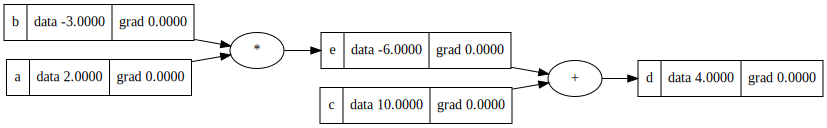

In [18]:
draw_dot(d) # The squares are Value objects. The ellipses are op nodes

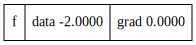

In [19]:
draw_dot(f)

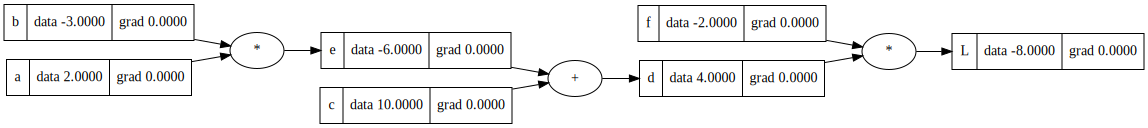

In [20]:
draw_dot(L) # In node d, grad is dL/dd (derivative of L with respect to d)

## Until now:
* I can get a mathematical expression (L) and I can represent the forward pass
* But, grad says always 0 because the backwards pass is not implemented

## Next step is to do the backprop pass.
* For that I need the derivative of L with respect to each node (d, f, c...)
* I want dL/dL, which is 1, but I want to imput it to all the other nodes.
* dL/df, dL/dd...
* And I can do this numerically, using the limit definition like above.
* For example, a + node will produce a 1.0 "local" derivative. (d = c + e, so dL/dc = dL/dd * dd/dc) and I know that dd/dc = 1
* However, when I get to a * node I get a different expression:

dL/da = dL/dd * dd/de * (de/da) -- see how to differentiate a product

**Important to note, I only have influence on the "leaf" nodes, like a, b, c and f, not on the intermediate nodes like d and e. Therefore, I only apply backprop to a, b, c and f.** 

Now I'm going to apply backpropagation to a neuron. It's more interesting that the previous example although it's going to be similar.

In [21]:
# Inputs: X1 and X2. With weights W1 and W2 and bias b.

x1 = Value(2.0, label = "X1")
x2 = Value(0.0, label = "X2")
W1 = Value(-3.0, label = "W1")
W2 = Value(1.0, label = "W2")
b = Value(6.88137, label = "b") # This number in particular for numerical reasons later.

# Now do the intermediate steps to have access to them.
X1W1 = x1 * W1; X1W1.label = "X1W1"
X2W2 = x2 * W2; X2W2.label = "X2W2"

X1W1X2W2 = X1W1 + X2W2; X1W1X2W2.label = "X1W1X2W2"

#For the moment I don't apply an activation.
n = X1W1X2W2 + b; n.label = "n"

# Output of the neuron, apply the activation
o = n.tanh(); o.label = "O" # And I implemented tanh before in Value





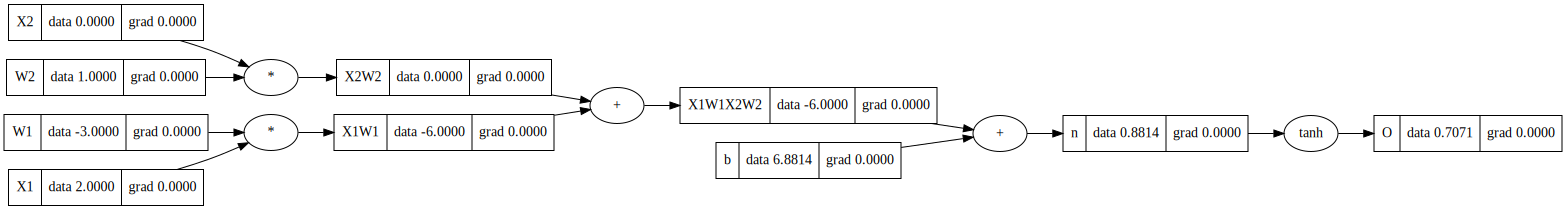

In [22]:
# And see if I can draw it

draw_dot(o)

In [23]:
# And now I check my implementation of _backward()

o.grad = 1.0 # Because it's initialized at 0, then everything is 0 and 0=0


In [24]:
o._backward() #And I can see the gradients changing from the graph above to the graph below

In [25]:
n._backward()

In [26]:
b._backward() # This is a leaf node, it shouldn't have a gradient

In [27]:
X1W1X2W2._backward()
X1W1._backward()
X2W2._backward()

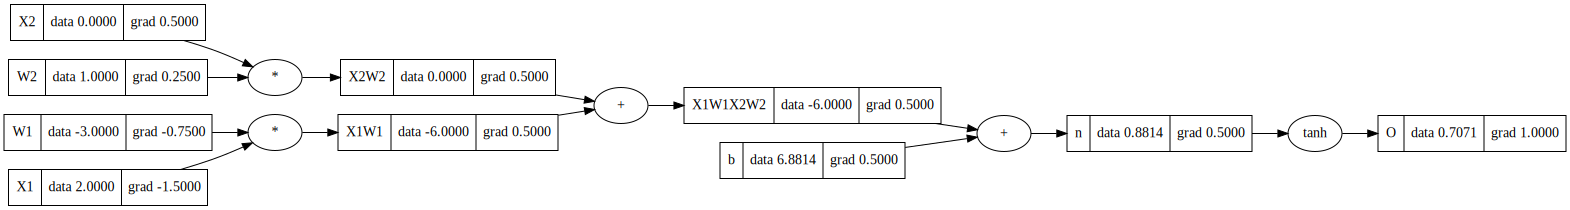

In [28]:
draw_dot(o)

In [29]:
# I know that by definition o.grad = do/do = 1

o.grad = 1.0

# And I also know that I want do/dn, with o = tanh(n). So one of the ways to compute dtanh(x)/dx = 1 - tanh(x)^2 = 1 - o^2

1- o.data**2

0.5000025364090595

Now, to avoid calling _backward() manually for each node, we need to make sure that everything that the current node needs (the children), it's already calculated. We can achieve this by ordering the graph using something called topological sort

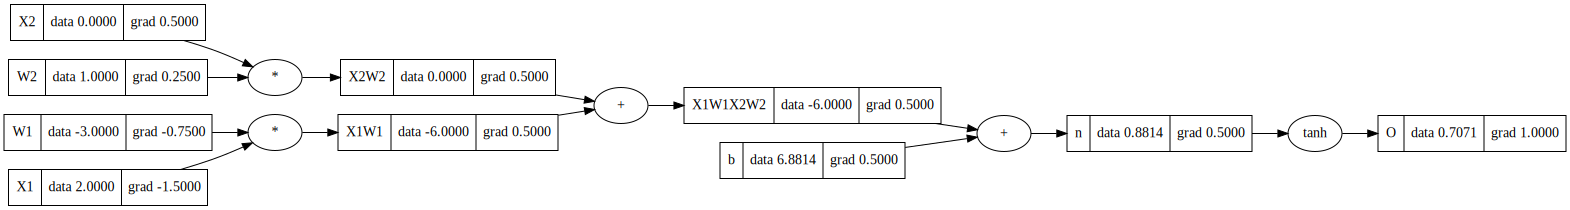

In [30]:
#o.backward()
draw_dot(o) # And this should be the same as above

In [34]:
# Now we change how we define the tanh

# Inputs: X1 and X2. With weights W1 and W2 and bias b.

x1 = Value(2.0, label = "X1")
x2 = Value(0.0, label = "X2")
W1 = Value(-3.0, label = "W1")
W2 = Value(1.0, label = "W2")
b = Value(6.88137, label = "b") # This number in particular for numerical reasons later.

# Now do the intermediate steps to have access to them.
X1W1 = x1 * W1; X1W1.label = "X1W1"
X2W2 = x2 * W2; X2W2.label = "X2W2"

X1W1X2W2 = X1W1 + X2W2; X1W1X2W2.label = "X1W1X2W2"

#For the moment I don't apply an activation.
n = X1W1X2W2 + b; n.label = "n"

# Output of the neuron, apply the activation
# New tanh definition!
#o = n.tanh(); 

e = (2 * n).exp()

o = (e - 1)/(e + 1)

o.label = "O" # And I implemented tanh before in Value
o.backward() # The gradients may not match because I may have run o.backward() earlier in the code. To check, run Value, and this again.



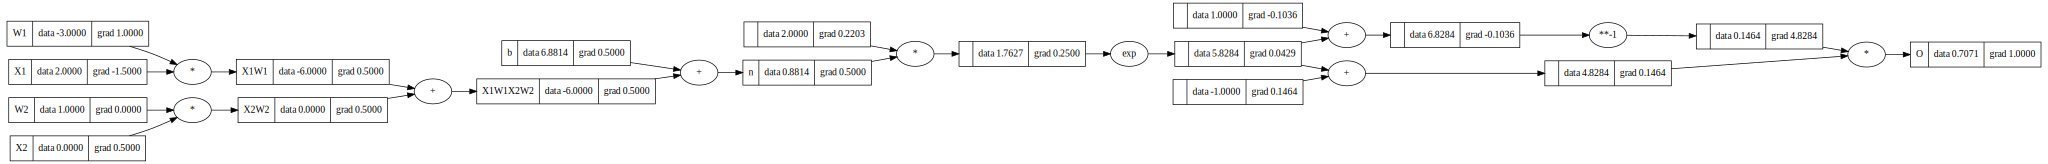

In [35]:
draw_dot(o)

Now we check the same thing with Pytorch. 

In [41]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # Value(x1) is the equivalent of Tensor. We cast it to double to compare with the Python version
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward() # This is the pytorch's implementation, not mine

print('---')
print('x2', x2.grad.item()) # Should be the same values as before
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


How about building a network?

In [56]:
class Neuron:
    def __init__(self, nin): # nin is number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # random initialization of weights and bias
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b) 
        out = act.tanh()

        return out

# A layer is just a set of independent neurons (connected to neurons in other layers, but not in the same one)

class Layer:
  
  def __init__(self, nin, nout): # Number of inputs and outputs
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


# And a neural network is jus a set of layers connected

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts # Size of a layer
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)

Value(data = -0.1482547115680573)

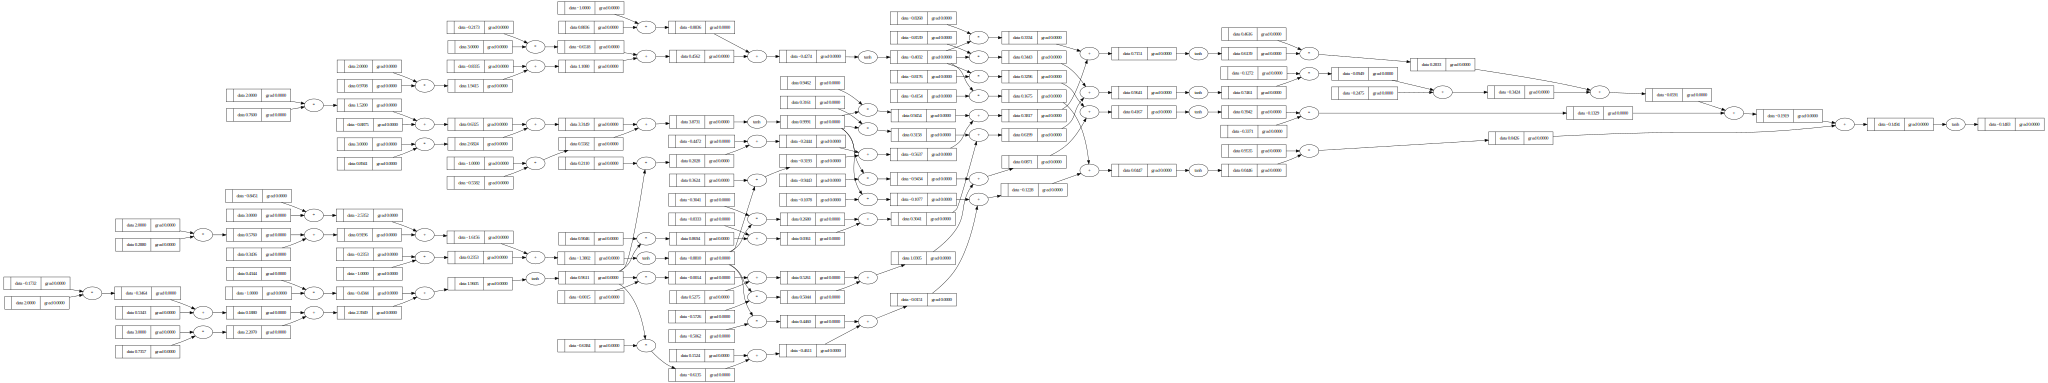

In [58]:
# It gets a bit complext to do the derivatives by hand, doesn't it?
draw_dot(n(x))

In [64]:
# Now make some fake data and a binary classifier

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_pred = [n(x) for x in xs]
y_pred # And this won't match, because the classifier is not trained

[Value(data = -0.1482547115680573),
 Value(data = -0.5299488529115229),
 Value(data = -0.7699009612303681),
 Value(data = -0.05399697375064651)]

In [66]:
loss = [(y_out - y_true)**2 for y_true, y_out in zip(ys, y_pred)]
loss

[Value(data = 1.3184888826382424),
 Value(data = 0.2209480808791931),
 Value(data = 0.05294556764270856),
 Value(data = 1.110909620675521)]

In [ ]:
#https://youtu.be/VMj-3S1tku0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=6808